# Imports

In [316]:
from sklearn.linear_model import Lasso, Ridge, LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import scipy.stats as stats 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from model_builder import ModelBuilder
from model_utils import *
import random
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import colorsys
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
plt.rcParams["font.family"] = "Times New Roman"
import warnings
warnings.filterwarnings("ignore")

In [317]:
with open("config.json", "rb") as json_file:
    config = json.load(json_file)
config

{'becker': {'filename': 'beckerestimation_output_conversation_level.csv',
  'cols_to_ignore': ['conversation_num',
   'mean_pre_discussion_error',
   'mean_post_discussion_error',
   'median_pre_discussion_error',
   'median_post_discussion_error',
   'median_pre_discussion_error_pct',
   'median_post_discussion_error_pct',
   'mean_pre_discussion_error_pct',
   'mean_post_discussion_error_pct',
   'reverse_mean_post_discussion_error_pct',
   'reverse_median_post_discussion_error_pct',
   'question',
   'chatrooms',
   'trial_indx']},
 'csop': {'filename': 'csop_output_conversation_level.csv',
  'cols_to_ignore': ['conversation_num',
   'batch_num',
   'round_num',
   'round_index',
   'task_index',
   'complexity',
   'type',
   'social_perceptiveness',
   'skill',
   'cogStyleDiversity',
   'skill_diversity',
   'normalized_score',
   'score',
   'duration',
   'efficiency']},
 'csopII': {'filename': 'csopII_output_conversation_level.csv',
  'cols_to_ignore': ['conversation_num',
   

In [318]:
def drop_invariant_columns(df):
    """
    Certain features are invariant throughout the training data (e.g., the entire column is 0 throughout).

    These feature obviously won't be very useful predictors, so we drop them.
    
    This function works by identifying columns that only have 1 unique value throughout the entire column,
    and then dropping them.

    @df: the dataframe containing the features (this should be X).
    """
    nunique = df.nunique()
    cols_to_drop = nunique[nunique == 1].index
    return(df.drop(cols_to_drop, axis=1))


In [319]:
def read_and_preprocess_data(path, min_num_chats, num_conversation_components = None):
	conv_data  = pd.read_csv(path)

	# Fill NA with mean
	conv_data.fillna(conv_data.mean(numeric_only=True), inplace=True)

	# Filter this down to teams that have at least min_num of chats
	# Can also comment this out to re-run results on *all* conversations!
	conv_data = conv_data[conv_data["sum_num_messages"] >= min_num_chats]


	# Save the important information

	# DV
	dvs = conv_data[["score","speed","efficiency","raw_duration_min","default_duration_min"]]

	# Team Composition
	composition_colnames = ['birth_year', 'CRT', 'income_max', 'income_min', 'IRCS_GS', 'IRCS_GV', 'IRCS_IB', 'IRCS_IR',
				'IRCS_IV', 'IRCS_RS', 'political_fiscal', 'political_social', 'RME', 'country', 'education_level',
				'gender', 'marital_status', 'political_party', 'race', 'playerCount']
	
	# Select columns that contain the specified keywords
	composition = conv_data[[col for col in conv_data.columns if any(keyword in col for keyword in composition_colnames)]]

	# Task
	task = conv_data[['task', 'complexity']].copy()

	task_map_path = '../utils/task_map.csv' # get task map
	task_map = pd.read_csv(task_map_path)

	task_name_mapping = {
		"Moral Reasoning": "Moral Reasoning (Disciplinary Action Case)",
		"Wolf Goat Cabbage": "Wolf, goat and cabbage transfer",
		"Guess the Correlation": "Guessing the correlation",
		"Writing Story": "Writing story",
		"Room Assignment": "Room assignment task",
		"Allocating Resources": "Allocating resources to programs",
		"Divergent Association": "Divergent Association Task",
		"Word Construction": "Word construction from a subset of letters",
		"Whac a Mole": "Whac-A-Mole"
	}
	task.loc[:, 'task'] = task['task'].replace(task_name_mapping)
	task = pd.merge(left=task, right=task_map, on = "task", how='left')
	
	# Create dummy columns for 'complexity'
	complexity_dummies = pd.get_dummies(task['complexity'])
	task = pd.concat([task, complexity_dummies], axis=1)   
	task.drop(['complexity', 'task'], axis=1, inplace=True)

	# Conversation
	conversation = conv_data.drop(columns= list(dvs.columns) + list(composition.columns))._get_numeric_data()
	conversation = drop_invariant_columns(conversation) # drop invariant conv features

	# additional preprocess --- get PC's of conversation to reduce dimensionality issues
	if(num_conversation_components):
		pca = PCA(n_components=num_conversation_components)
		pca_result = pca.fit_transform(conversation.transform(lambda x: (x - x.mean()) / x.std()))
		print("PCA explained variance:")
		print(np.sum(pca.explained_variance_ratio_))
		conversation = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])

	return composition, task, conversation, dvs

In [320]:
min_num_chats = 0
data_path = "../output/"
tiny_multitask = 'conv/multi_task_TINY_output_conversation_level_stageId_cumulative.csv'
multitask_cumulative_by_stage = 'conv/multi_task_output_conversation_level_stageId_cumulative.csv'
multitask_cumulative_by_stage_and_task = 'conv/multi_task_output_conversation_level_stageId_cumulative_within_task.csv'

Note: Currently using multitask, cumulative by stage and task

In [321]:
team_composition_features, task_features, conv_features, targets = read_and_preprocess_data(data_path + multitask_cumulative_by_stage_and_task, min_num_chats=min_num_chats)

In [322]:
tasks = pd.read_csv(data_path + multitask_cumulative_by_stage)["task"].to_frame().rename(columns={"task": "task_name"})

# Down-Selection via Domain Knowledge

In [323]:
# Quantity
quantity = "num_chars"
total_messages = "sum_num_messages"

# Pace
pace = "time_diff"

# Content and Engagement
lexicons_and_content = ["money", "stopword", "TTR"]
politeness_strategies = ["please","please_start","hashedge","indirect_btw","hedges","factuality","deference","gratitude","apologizing","1st_person_pl","1st_person","1st_person_start","2nd_person","2nd_person_start","indirect_greeting","direct_question", "direct_start","haspositive","hasnegative","subjunctive","indicative"]

# Equality
equality = "gini_coefficient_sum_num_chars"

# Emotion
emotion = "positive_bert"

# Variance
variance = "mimicry_bert"

# A really small set of features!
# handpicked_colnames = [col for col in conv_features.columns if any(name in col for name in ["num_chars", "positive_bert"])]
handpicked_colnames = [col for col in conv_features.columns if any(name in col for name in politeness_strategies + lexicons_and_content + [quantity, pace, emotion, variance])]

In [324]:
def apply_rules(colname):
    if("user" in colname): return False
    if("average" not in colname and "stdev" not in colname): return False
    else:
        return True

handpicked_colnames = [col for col in handpicked_colnames if apply_rules(col)]

handpicked_colnames = handpicked_colnames + [equality, total_messages]

In [325]:
len(handpicked_colnames)

56

In [326]:
conv_features = conv_features[handpicked_colnames]

In [327]:
conv_plus_tasklabels = pd.concat([conv_features,tasks], axis = 1)

# PCA of Datasets

How do people "speak differently" across different tasks? Can we identify these different patterns of speaking just through clustering each conversation?

In [328]:
### Using Performance as labels
targets["score_binary"] = np.where(targets["score"] == 100, 1, 0)

In [329]:
labels_score = [0, 1]

In [330]:
labels = list(tasks["task_name"].unique())

In [331]:
def split_dataframes(df, grouper):    
    grouped_df = df.groupby(grouper)
    return([group_df for group_name, group_df in grouped_df])

In [332]:
conv_task_plus_scorelabels = pd.concat([conv_features,task_features,targets["score_binary"]], axis = 1)
conv_plus_scorelabels = pd.concat([conv_features,targets["score_binary"]], axis = 1)
task_plus_scorelabels = pd.concat([task_features,targets["score_binary"]], axis = 1)

In [333]:
# Coloring by performance
# pca_results = pca_results = plot_2d_dataframes(*split_dataframes(conv_plus_scorelabels, grouper = "score_binary"), labels=labels_score, pca = True, legend_label = "Success", title = "PCA Scatter Plot of Conversations (By Performance)")

In [335]:
# pca_results = plot_2d_dataframes(*split_dataframes(conv_plus_tasklabels, grouper = "task_name"), labels=labels, title = "PCA Scatter Plot of Conversations (By Task)")

In [336]:
# pca_results.explained_variance_ratio_

In [337]:
# examine_top_n_components(pca_results, n=10)

PC 1 mostly captures *the quantity of how much people talk*.

## How much do all the other PC's tell us?
Answer: not a ton...

In [650]:
full_pca = get_pca_of_dataframes(split_dataframes(conv_plus_tasklabels), n_components = 10)

([<matplotlib.axis.XTick at 0x147a9dca0>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9')])

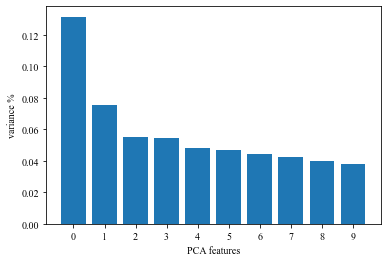

In [651]:
var = full_pca.explained_variance_ratio_
plt.bar(list(range(var.shape[0])),var)
feature = range(full_pca.n_components_)
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(feature)

# PCA of Features

Can we now model each feature as a point, and see how the different features relate to each other?

(The following code generates an interactive PCA plot, but opens in a brower window.)

Columns with NaN values: []
Rows with NaN values: []


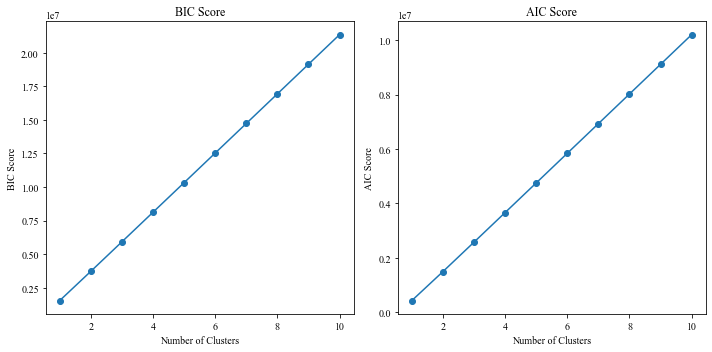

In [351]:
visualize_feature_clusters(split_dataframes(conv_plus_tasklabels), use_aic = True, title = "PCA Scatter Plot of Conversational Features")

Columns with NaN values: []
Rows with NaN values: []


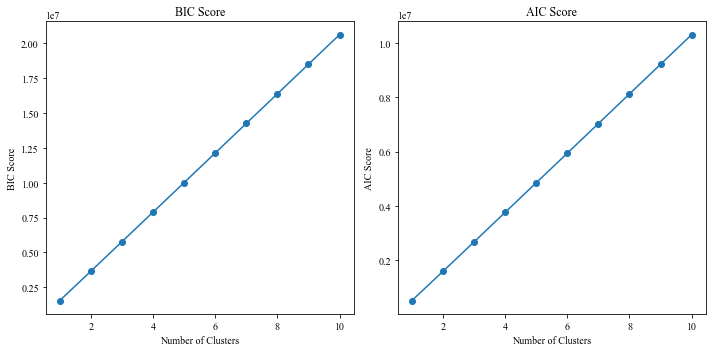

In [275]:
# Get more insight into the clusters!
all_data = pd.concat(split_dataframes(conv_plus_tasklabels), join = 'inner', ignore_index = True)

'''
The below reproduces the code from inside the plotting function, but gives us access to the actual cluster labels to 
play around with!
'''

# Normalize (Across all tasks)
columns_to_normalize = [col for col in all_data.columns if col != 'task_name']
normalized_df = all_data.copy()
normalized_df[columns_to_normalize] = normalized_df[columns_to_normalize].transform(lambda x: (x - x.mean()) / x.std())

# Drop NA columns
nan_cols, nan_rows = check_na_rows_cols(normalized_df)
normalized_df = normalized_df.drop(nan_cols, axis = 1)

normalized_data_transposed = normalized_df.drop(["task_name"], axis=1).T

# Get Clusters (using GMM) for the data, on the full-dimensional dataset.
cluster_labels = get_gaussian_mixture_clustering(normalized_data_transposed, use_aic=True)

In [276]:
normalized_data_transposed["cluster"] = cluster_labels

In [277]:
def explore_clustered_features(df, num_closest=5):
    unique_clusters = df['cluster'].unique()
    nearest_points_df = pd.DataFrame()

    for cluster_label in unique_clusters:
        cluster_data = df[df['cluster'] == cluster_label]
        features = cluster_data.drop(columns=['cluster'])

        centroid = features.mean(axis=0)
        similarity_scores = cosine_similarity([centroid], features).flatten()

        # Get the num_closest data points with highest similarity
        nearest_indices = np.argsort(similarity_scores)[-num_closest:]
        nearest_cluster_points = cluster_data.iloc[nearest_indices]
        nearest_points_df = pd.concat([nearest_points_df, nearest_cluster_points])

    return nearest_points_df

Explore the top n (=10) features per cluster, by examining the closest features to the cluster centroid. What is "most representative" of the cluster?

TODO: these clusters are not super interpretable...

In [278]:
top_10_features_per_cluster = explore_clustered_features(normalized_data_transposed, num_closest = 10)
pca = PCA(n_components=2)
pca_top = pca.fit_transform(top_10_features_per_cluster.drop(["cluster"], axis = 1))

# Create a new DataFrame with the PC scores and row names
pca_df = pd.DataFrame(data=pca_top, columns=["PC1", "PC2"], index=top_10_features_per_cluster.index)
pca_df["cluster"] = top_10_features_per_cluster["cluster"]

generate_interactive_feature_plot(pca_df, "PCA of Top 5 Features Per Cluster")

## PCA of User Features

In [279]:
users = pd.read_csv('../output/user/multi_task_output_user_level_stageId_cumulative.csv')

In [280]:
task_key = pd.read_csv(data_path + multitask_cumulative_by_stage)[["task", "conversation_num"]].rename(columns={"task": "task_name"})

In [281]:
user_df = users.merge(task_key, on="conversation_num", how = "left").drop(["conversation_num", "speaker_nickname", "user_list"], axis = 1)

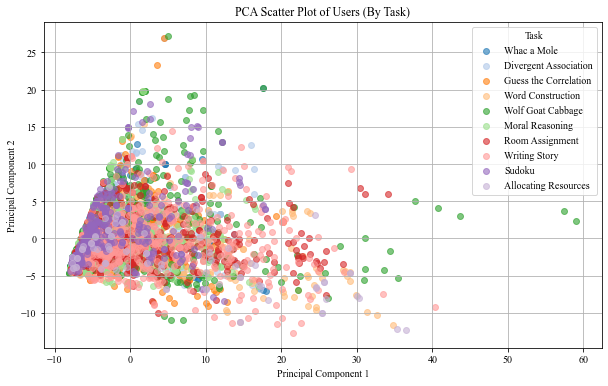

In [285]:
pca_results_users = plot_2d_dataframes(*split_dataframes(user_df), labels=labels, title = "PCA Scatter Plot of Users (By Task)")

In [283]:
pca_results_users.explained_variance_ratio_

array([0.27937154, 0.08557683])

In [284]:
examine_top_n_components(pca_results_users, n=10)

Top 5 Features for PC1:
                                        Feature       PC1       PC2   PC1_abs  \
100                               sum_num_words  0.132405 -0.031504  0.132405   
158  sum_nltk_english_stopwords_lexical_per_100  0.131971 -0.022063  0.131971   
151          sum_cognitive_mech_lexical_per_100  0.131796 -0.015630  0.131796   
101                               sum_num_chars  0.131713 -0.023263  0.131713   
146                   sum_verbs_lexical_per_100  0.130331 -0.034166  0.130331   
150         sum_auxiliary_verbs_lexical_per_100  0.127941 -0.030526  0.127941   
128           sum_present_tense_lexical_per_100  0.127664 -0.037625  0.127664   
108             sum_conjunction_lexical_per_100  0.125686 -0.010124  0.125686   
152             sum_preposition_lexical_per_100  0.125078 -0.001065  0.125078   
136      sum_indefinite_pronoun_lexical_per_100  0.123752 -0.036146  0.123752   

      PC2_abs  
100  0.031504  
158  0.022063  
151  0.015630  
101  0.023263  
146 

,Feature,PC1,PC2,PC1_abs,PC2_abs
0,average_positive_bert,-0.029555,-0.102386,0.029555,0.102386
1,average_negative_bert,0.038438,0.092661,0.038438,0.092661
2,average_neutral_bert,-0.003825,0.026218,0.003825,0.026218
3,average_num_words,0.073544,0.194566,0.073544,0.194566
4,average_num_chars,0.072271,0.190552,0.072271,0.190552
...,...,...,...,...,...
192,sum_hasnegative,0.113191,-0.024608,0.113191,0.024608
193,sum_subjunctive,0.003719,-0.004177,0.003719,0.004177
194,sum_indicative,0.024425,-0.010560,0.024425,0.010560
195,sum_forward_flow,0.102189,-0.124156,0.102189,0.124156
